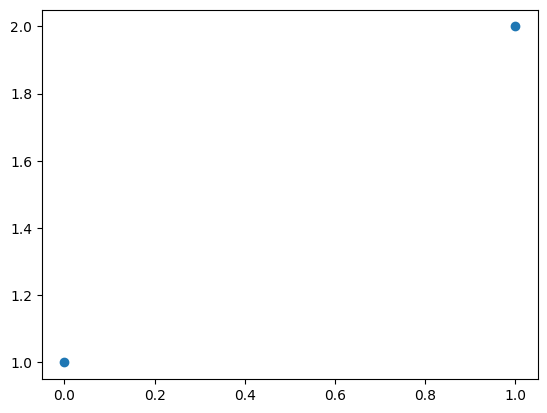

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward_old
import seis_forward
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

In [21]:
importlib.reload(kgs)
data = kgs.Data()
data.seismogram.filename = 'F:\\seismic\\data\\train_samples\\FlatVel_A/data\\data1.npy'
data.seismogram.ind=5
data.velocity = kgs.Velocity()
data.velocity.filename = 'F:\\seismic\\data\\train_samples\\FlatVel_A/model\\model1.npy'
data.velocity.ind=5
data.check_constraints()
data.load_to_memory()
#data.unload()

In [22]:
importlib.reload(kgs)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()

10000


In [42]:
%%time
importlib.reload(seis_forward)
kgs.profiling=True
d = data[2059]
print(d.family)
d.load_to_memory()
#seis_pred = seis_forward.vel_to_seis(data[0].velocity.data, data[0].velocity.min_vel)
for ind in range(10):
    seis_pred = seis_forward.vel_to_seis(d.velocity, d.seismogram).data
    kgs.profiling=False
#seis_pred = seis_forward.vel_to_seis(data[0].velocity.data,data[0].velocity.min_vel)[:,2:,:]
kgs.rms(seis_pred[:,:,:]-d.seismogram.data[:,:,:])    

CurveVel_A
Timer unit: 1e-07 s

Total time: 0.38489 s
File: f:\seismic/code/core\seis_forward.py
Function: vel_to_seis at line 184

Line #      Hits         Time  Per Hit   % Time  Line Contents
   184                                           @kgs.profile_each_line
   185                                           def vel_to_seis(velocity,seismogram):
   186         1        405.0    405.0      0.0      velocity.check_constraints()
   187         1          2.0      2.0      0.0      seis_combined = []
   188         6         30.0      5.0      0.0      for i_source in range(5):
   189         5    1964867.0 392973.4     51.1          temp1,temp2,nx,nz,nt,c2,c3,alpha,src_idx,s_mod,igz,igx=prep_run(velocity,i_source)
   190                                           
   191         5        682.0    136.4      0.0          temp1_flat= temp1.ravel()
   192         5        221.0     44.2      0.0          temp2_flat= temp2.ravel()
   193         5        208.0     41.6      0.0          

array(3.53638395e-05)

In [13]:
%debug

> f:\seismic\code\analysis\cupy\_core\_kernel.pyx(145)cupy._core._kernel._preprocess_arg()



ipdb>  u


> f:\seismic\code\analysis\cupy\_core\_kernel.pyx(159)cupy._core._kernel._preprocess_args()



ipdb>  u


> f:\seismic\code\analysis\cupy\_core\_kernel.pyx(1286)cupy._core._kernel.ufunc.__call__()



ipdb>  u


> f:\seismic\code\analysis\cupy\_core\core.pyx(1699)cupy._core.core._ndarray_base.__array_ufunc__()



ipdb>  u


> f:\seismic\code\analysis\cupy\_core\core.pyx(1291)cupy._core.core._ndarray_base.__mul__()



ipdb>  u


> f:\seismic\code\core\seis_forward.py(183)prep_run()
    181 
    182     bdt = beta_dt[isz, isx]
--> 183     s_mod = bdt*s
    184     recv_idx = (igz*nx + igx).astype(np.int32)
    185 



ipdb>  print(s)


[-1.64441317e-04 -2.20462645e-04 -2.94129881e-04 -3.90496539e-04
 -5.15896597e-04 -6.78217136e-04 -8.87213841e-04 -1.15487175e-03
 -1.49581242e-03 -1.92774696e-03 -2.47197195e-03 -3.15390240e-03
 -4.00363228e-03 -5.05650859e-03 -6.35369994e-03 -7.94273493e-03
 -9.87797908e-03 -1.22210126e-02 -1.50408642e-02 -1.84140506e-02
 -2.24243629e-02 -2.71623406e-02 -3.27243661e-02 -3.92113167e-02
 -4.67267099e-02 -5.53742869e-02 -6.52549889e-02 -7.64632959e-02
 -8.90829207e-02 -1.03181876e-01 -1.18806963e-01 -1.35977772e-01
 -1.54680319e-01 -1.74860489e-01 -1.96417505e-01 -2.19197678e-01
 -2.42988731e-01 -2.67515041e-01 -2.92434130e-01 -3.17334786e-01
 -3.41737167e-01 -3.65095210e-01 -3.86801651e-01 -4.06195877e-01
 -4.22574735e-01 -4.35206361e-01 -4.43346917e-01 -4.46260017e-01
 -4.43238483e-01 -4.33627901e-01 -4.16851327e-01 -3.92434355e-01
 -3.60029645e-01 -3.19439956e-01 -2.70638650e-01 -2.13786670e-01
 -1.49245025e-01 -7.75819062e-02  4.26270490e-04  8.38004363e-02
  1.71371347e-01  2.61799

ipdb>  type(s)


<class 'numpy.ndarray'>


ipdb>  type(bdt)


<class 'cupy.ndarray'>


ipdb>  q


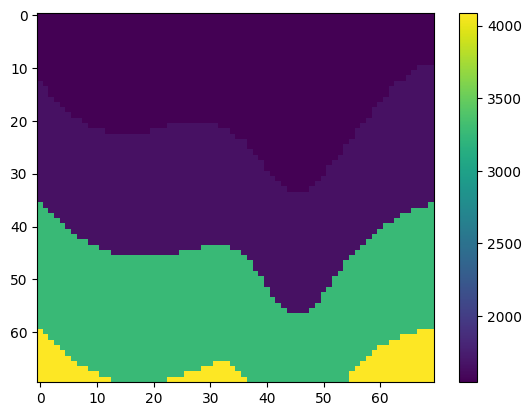

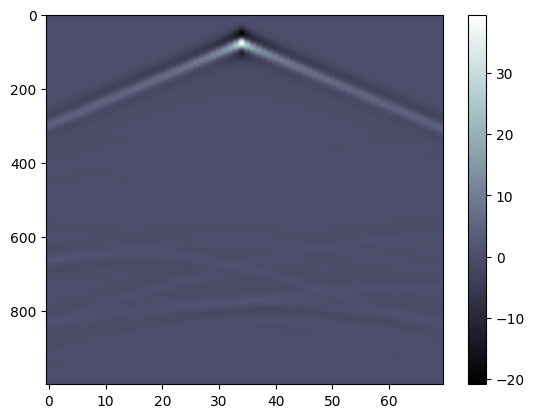

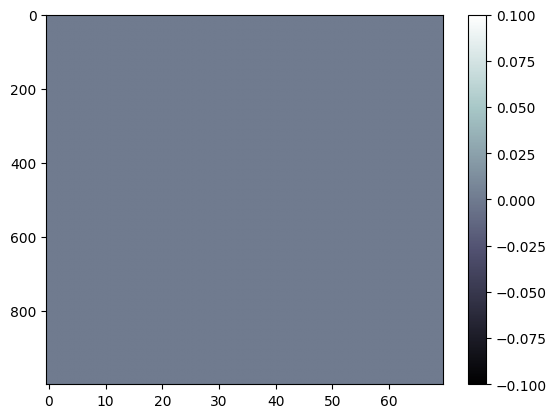

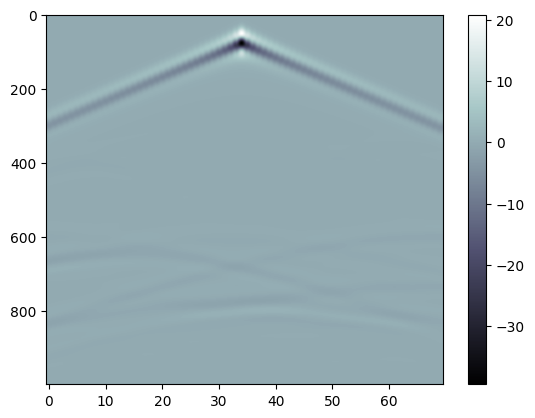

In [ ]:
import cupy as cp
plt.figure();plt.imshow(cp.asnumpy(d.velocity.data),aspect='auto');plt.colorbar()
plt.figure();plt.imshow(cp.asnumpy(d.seismogram.data[2,...]),cmap='bone',aspect='auto');plt.colorbar()        
plt.figure();plt.imshow(cp.asnumpy(seis_pred[2,...]),cmap='bone',aspect='auto');plt.colorbar()     
plt.figure();plt.imshow(cp.asnumpy(seis_pred[2,:,:]-d.seismogram.data[2,...]),cmap='bone',aspect='auto');plt.colorbar()

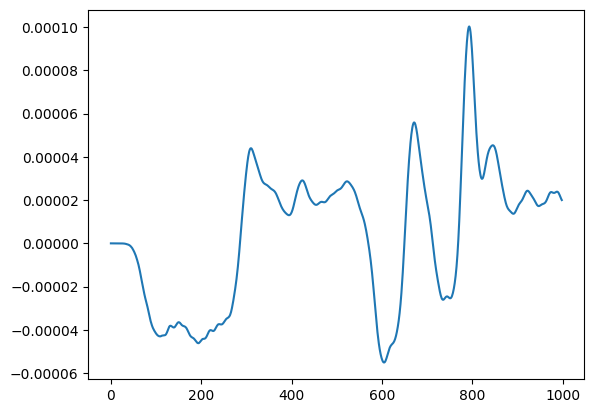

In [6]:
xx=seis_pred[2,:,:]-d.seismogram.data[2,...]
plt.plot(np.mean(xx,axis=1))

CurveFault_A 0.00010645790398319054


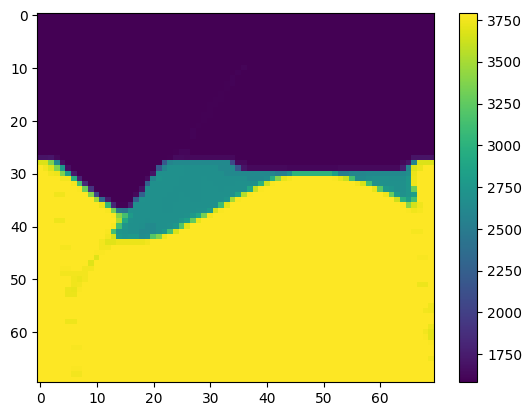

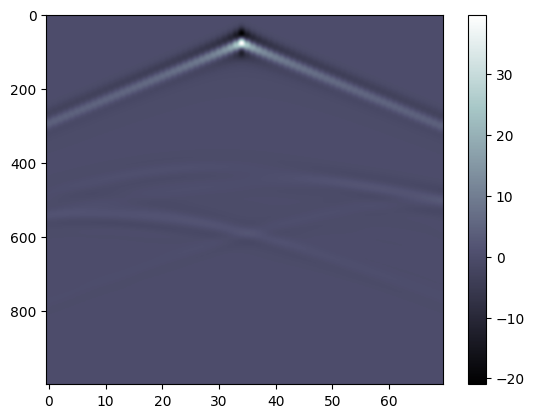

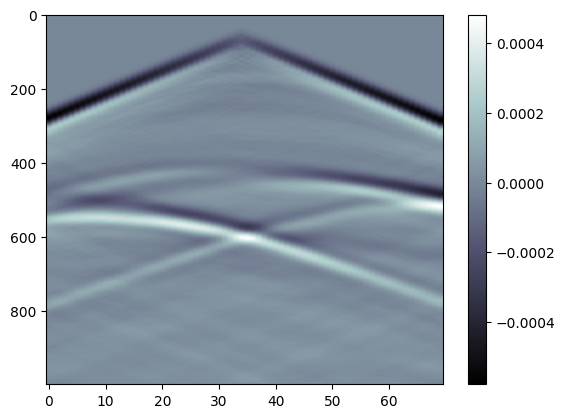

65
CurveFault_A 99 100 0.99
CurveFault_B 100 100 1.0
CurveVel_A 100 100 1.0
CurveVel_B 100 100 1.0
FlatFault_A 0.00012299945606680893


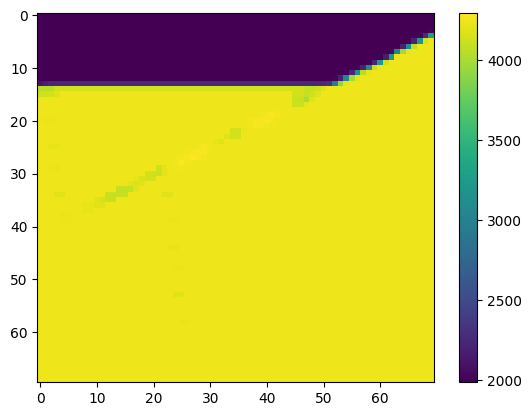

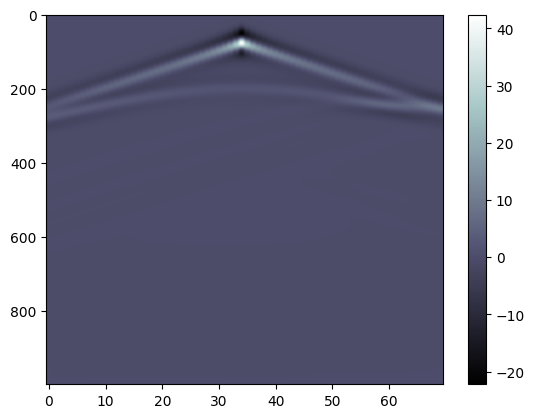

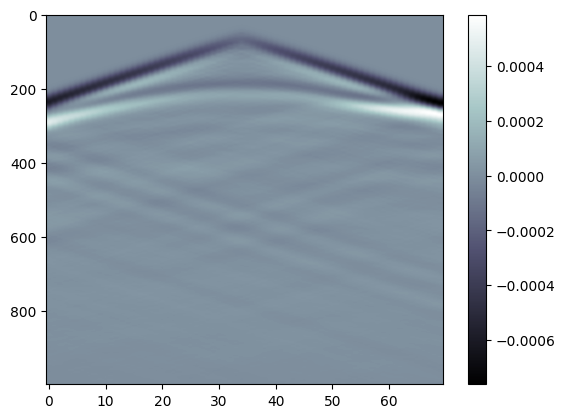

4030
FlatFault_A 99 100 0.99
FlatFault_B 100 100 1.0
FlatVel_A 100 100 1.0
FlatVel_B 0.00010017251957226519


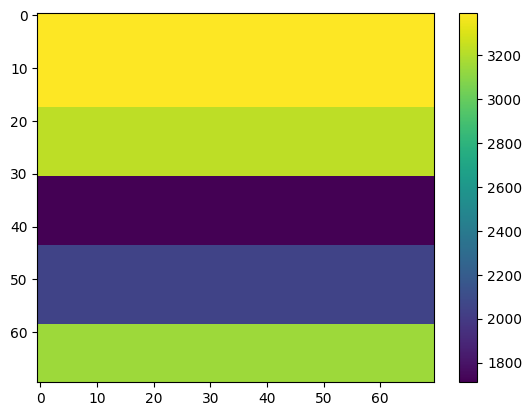

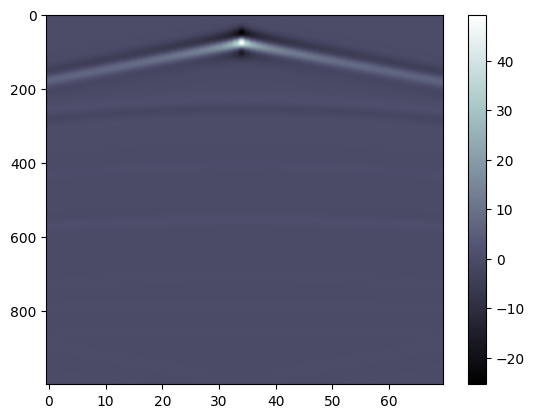

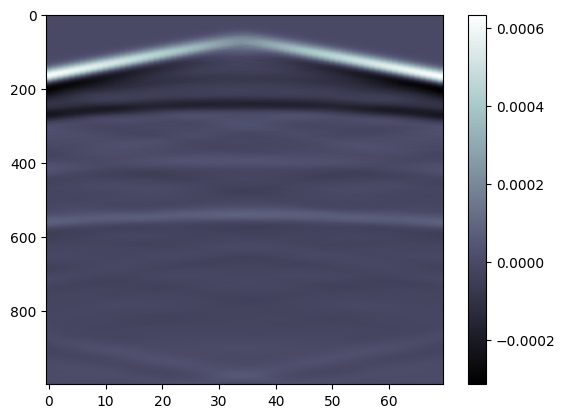

7008
FlatVel_B 0.0001082168074179129


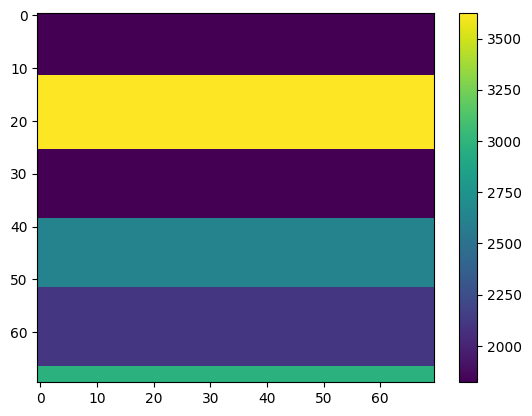

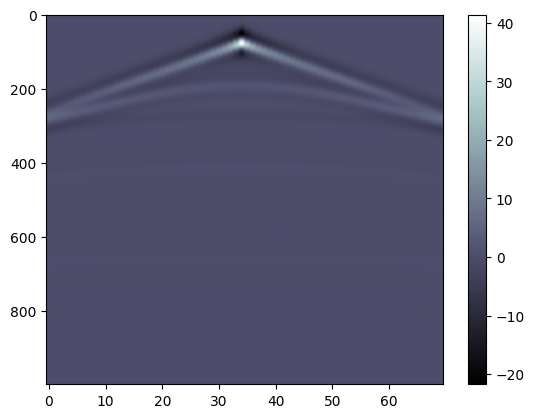

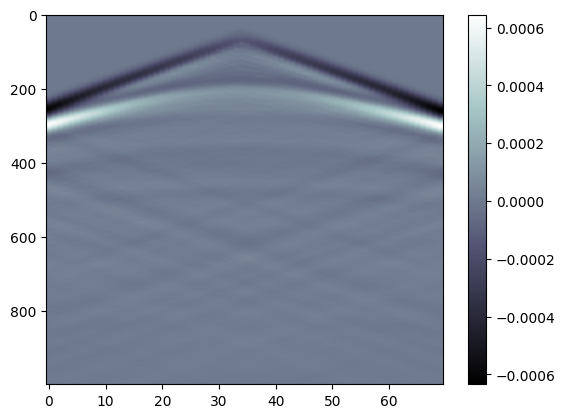

7038
FlatVel_B 0.00010701247437879232


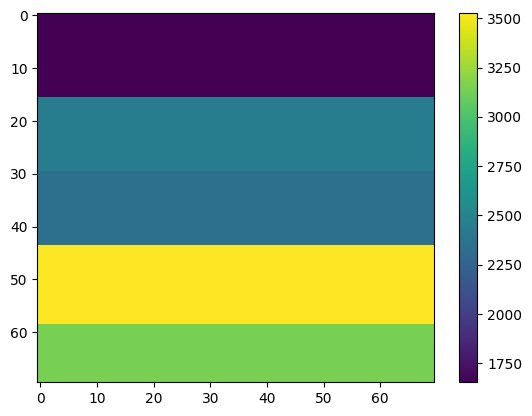

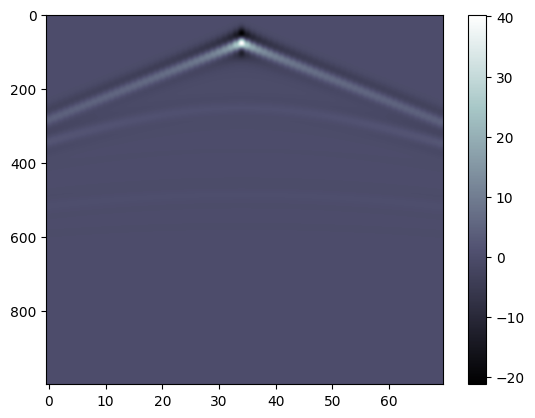

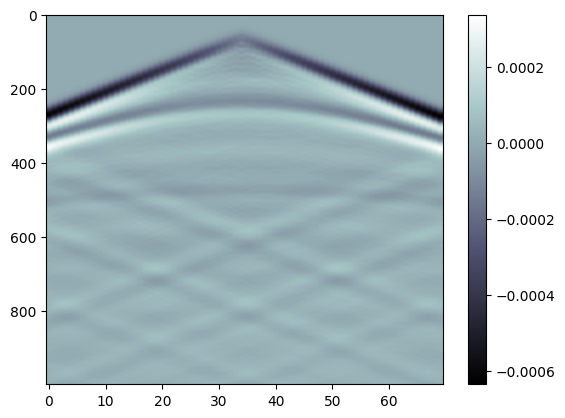

7081
FlatVel_B 0.00010333811632020109


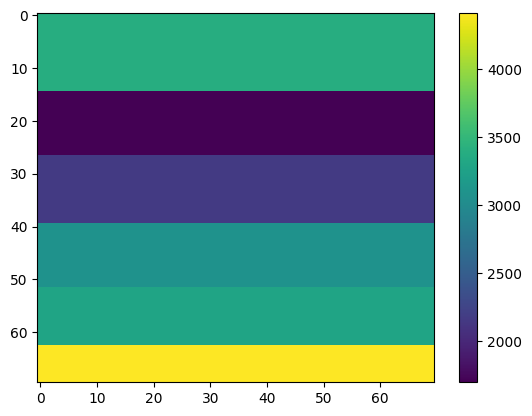

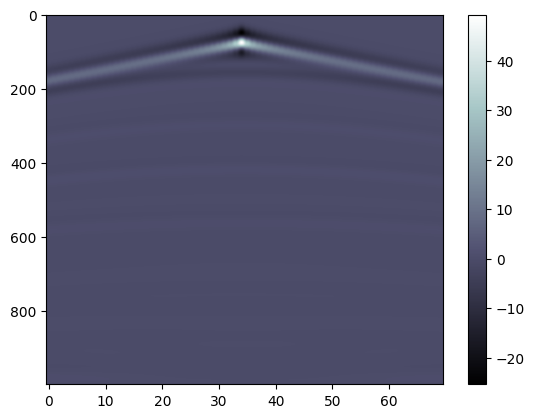

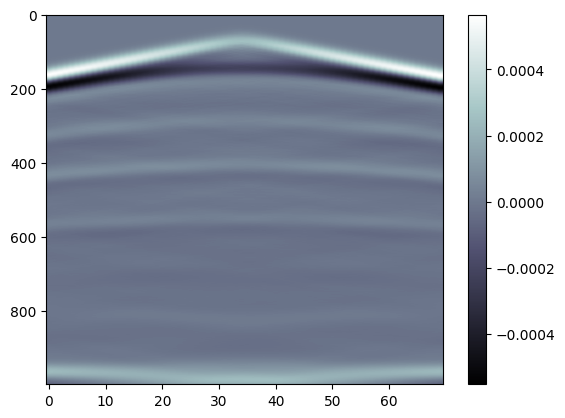

7096
FlatVel_B 96 100 0.96
Style_A 100 100 1.0
Style_B 100 100 1.0


In [7]:
data_shuffled = copy.deepcopy(data)
#np.random.default_rng(seed=0).shuffle(data_shuffled)
families = list(dict.fromkeys([d.family for d in data]))
for f in families:
    n_ok = 0
    n_done = 0
    for i,d in enumerate(data_shuffled):
        if not d.family==f:
            continue
        d.load_to_memory()
        seis_pred = seis_forward.vel_to_seis(d.velocity,d.seismogram).data
        if kgs.rms(seis_pred[:,:,:]-d.seismogram.data[:,:,:])<1e-4:
            #print('OK')
            n_ok+=1
        else:            
            pass
            print(d.family, kgs.rms(seis_pred[:,:,:]-d.seismogram.data[:,:,:]))              
            plt.figure();plt.imshow(d.velocity.data,aspect='auto');plt.colorbar()
            plt.figure();plt.imshow(d.seismogram.data[2,...],cmap='bone',aspect='auto');plt.colorbar()        
            plt.figure();plt.imshow(seis_pred[2,:,:]-d.seismogram.data[2,...],cmap='bone',aspect='auto');plt.colorbar()
            plt.pause(0.001)
            print(i)
        d.unload()
        n_done += 1
        if n_done>=100:
            break
    print(f,n_ok, n_done, n_ok/n_done)